# 1. Import all required Modules and custom build Classes into the Jupyter notebook
Import all required modules for the project.<br />
Import all custom modules for the project and instantiate classes using the config file.<br />
Custom modules can now be called directly in the notebook.


In [1]:
import sys
from sys import getsizeof as dictsize
import os
import json
import time
import pymongo
import urllib
import pandas as pd
import numpy as np
import urllib
import urllib.request
import missingno as msno
import zipfile 
import io

try:
    import createNewData.data.config as in_config
    from createNewData.pypackages.Azure import Azure
    from createNewData.pypackages.urlHandler import UrlHandler
    AzurePackage = Azure(in_config)
    Url = UrlHandler(in_config)
    
    
except ImportError as e:
    print(in_config.FailedImport)
    print(e)

# 2. Upload to SQL Database
Download the entire GTFS data and upload to the Azure SQL Database.
Required fields:
* "UploadToSQL": The class name for the Azure constructor for uploading tables to the database.
* GTFSDF:  The dataframes to be written to the database.
* tablename: The name of the new table to be created.
* teamConnQuote: The connection string for the team SQL Database obtained from the config file.

In [ ]:
GTFS = requests.get(in_config.GTFSURL, stream=True)
GTFSRaw = zipfile.ZipFile(io.BytesIO(GTFS.content))

for each in GTFSRaw.namelist():
    GTFSDF = pd.read_csv(GTFSRaw.open(each), low_memory=False)
    tableName = each.replace(".txt","")
    AzurePackage("UploadToSQL",
                  GTFSDF,
                  tableName,
                  in_config.teamConnQuote)

# 3. Return All Unique Stop Id's From SQL Database
1. Collect all items in the '' schema of shared team Database
2. Reduce Dataframe by removing dupicate coordinates.
3. Pop() coordinates based on batch sizes no greater than 1024 bytes.
4. Add each batch list to a list of batches to send the the Open-elevations API

### Attributes
* Azure class imported with call functionality (in)
* Config File (in)
* listOfBatches (out)


In [27]:
listOfBatches = []
batches = {"locations" : []}

try:
    df = pd.read_csv("ingestRawData\gtfs\shapes.txt")
    shapesDF = df[["shape_id", "shape_pt_lat","shape_pt_lon"]]
    shapesRequest = shapesDF.drop_duplicates(subset=None, 
                                        keep='first', 
                                        inplace=False)
    shapesCoordinates = Url("generateLocationRequest", shapesRequest)
    for key, value in shapesCoordinates.items():
        if key == "locations":
            locations = value
    while len(locations) != 0:
        for each in locations:
            if dictsize(batches["locations"]) +\
                                dictsize(each) +\
                                dictsize(batches) < 9700:
                location = locations.pop(0)
                batches["locations"].append(location)
            else:
                location = locations.pop(0)
                batches["locations"].append(location)
                listOfBatches.append(batches)
                batches = {"locations" : []}
        for each in listOfBatches:
            if dictsize(each) > 10000:
                raise Exception(in_config.RequestToBig)
            else:
                pass
    else:
        print("All values added to the list of requests.")
except pd.io.sql.DatabaseError as e:
    print(in_config.NoSQLShema)

except urllib.request.HTTPError as e:
    if e.code == "403":
        print(in_config.SQLConnectionFail)
    
except Exception as e:
    print(in_config.UNKMGO)
    print(e)


845


In [ ]:
# Create Request Batches

In [ ]:
listOfObjects = []
listOfElevations = []
ListOfDicts = []

Iteration = 0
try:
    for each in listOfBatches:
            attempts = 0
            while attempts < 5:
                try:
                    ListOfDicts.append(Url("mineElevationData",each))
                    break
                except urllib.error.HTTPError:
                    attempts = attempts+1
            Iteration = Iteration + 1
            print(Iteration)
            time.sleep(2)
    for each in ListOfDicts:
        for key, value in each.items():
            if type(value) is list:
                listOfObjects.append(value)

    for each in listOfObjects:
        for elevation in each:
            listOfElevations.append(elevation)
        

    df = pd.DataFrame(listOfElevations)
    dfTrimmed = df.drop_duplicates()
    sumElevation = dfTrimmed["elevation"].sum()
    if type(sumElevation) in [np.int64,int]:
        print("Elevations collected correctly")
        print(dfTrimmed.head())
    else: 
        raise Exception("Failed to collect all elevations, please try again.")
except KeyError as e:
    print(f"Column {e} cannot be found in the dataframe.")
except NameError as e:
    print(f"The Datatable {e} cannot be found.")
except Exception as e:
    print(in_config.UNKMGO)
    print(type(e))
    print(e)

    

# Save Trimmed Elevation Data Team SQL Database
This reads data from the raw Json files in the MongoDB database and imports them to a dataframe that contains only unique values. Removing any rows where any full row duplicates exist.
This saves the resulting SQL schemata to the Database used by the R-Shiny app. (Production)
This will overwrite any existing data in the SQL schemata that already exists.

In [30]:
SqlDataCursor = AzurePackage("UploadToSQL",
                              dfTrimmed,
                              "elevations",
                              in_config.teamConnQuote)

NameError: name 'dfTrimmed' is not defined

# Collect Elevation Data and Upload to MongoDB
Collect the longtitude and lattitude for elevation data from the shapes table.
Store data to the mongoDB database in Azure Cosmos.

In [ ]:
shapeList = []
AzurePackage("DropMongoColl","shapes")
for each in shapeIds.iterrows():
    try:
        # Generate the Pandas table of all the Longtitudes and Latitudes
        # for each shape
        elevations = AzurePackage("SelectLongLat",
                                "[shape_id],[shape_pt_lat],[shape_pt_lon]",
                                "[dbo].[shapes]",
                                "[shape_id]",
                                each[1][0])

        # Generate the Json document for upload to MongoDB
        shapeData = Url("mineElevationData",elevations)
    except urllib.error.HTTPError as e:
        print(in_config.URLOOD)
        print(e)

    try:
        # Upload the Json document to MongoDB
        if not len(shapeData) == 0:
            AzurePackage("UploadToMongo","shapes",shapeData)
        else:
            raise Exception(in_config.NDIDF)
    except TypeError as e:
        print(in_config.TEC)
    except pymongo.errors.DuplicateKeyError as e:
        print(in_config.FIDB)
    except Exception as e:
        print(in_config.UNKMGO)
        print(e)



# Read Data From MongoDB and Write to Pandas DataFrame
This reads data from the raw Json files in the MongoDB database and imports them to a dataframe that contains only unique values. 
Removing any rows where any full row duplicates exist.<br />
Finally, this tests that all the elevation data was collected correctly by summing the values of the elevations and therefore ruling out any NaN values. An exception will be raised here in the final script to indicate that the elevation collection was unsuccessfull.

# Upload Trimmed Elevations DataFrame to SQL

This saves the resulting SQL schemata to the development database.
This will overwrite any existing data in the SQL schemata that already exists.


In [5]:
dfTrimmed = pd.read_csv(r"C:\Users\James\Documents\MSc in Data Analytics\Database and Ananytics\Research Project\dapTbElectricDublinBus\Elevations.csv")
SqlDataCursor = AzurePackage("UploadToSQL",
                              dfTrimmed,
                              "elevations",
                              in_config.teamConnQuote)

# Collect real time data and upload to Mongo
This collects the real time data as a json file and overwrites the collection in the mongoDB database.
* URL used https://gtfsr.transportforireland.ie


In [5]:
url = in_config.url2
headers = in_config.RTIheaders
response = Url("callURL", url, {}, headers)
JsonData = response.read().decode('utf8').replace("'", '"')
RTIgtfs = json.loads(JsonData)
try:
    AzurePackage("UploadToMongo","RTIgtfs",RTIgtfs)
except pymongo.errors.WriteError as e:
    print("An error occured while attempting to write the GTFS data to Mongo Database.")
    print(type(e))
except HTTPError as e:
    print("An error occured while attempting to connect to the CosmosDB Database.")
    print(type(e))


KeyboardInterrupt: 

# Connect the shape and elevation schema together by joining their longtitude and latatude values
This will either be a method in the Rshiny app to collect or we simply create a new database from this data but this seems a bit verbose.

In [62]:
conn = AzurePackage("AzureDBConn", in_config.teamConnQuote)
SQLTrips = """SELECT distances.route_id, 
                     distances.service_id, 
                     distances.quasi_block,
                     distances.trip_id
               FROM distances
               GROUP BY distances.route_id, distances.service_id, distances.quasi_block, distances.trip_id
               """

SQLShapes = f"""SELECT shapes.shape_id, elevations.elevation
                FROM shapes
                LEFT JOIN elevations ON
                shapes.shape_pt_lon = elevations.longitude 
                AND shapes.shape_pt_lat = elevations.latitude
                """
tripsIds = pd.read_sql(SQLTrips, conn)
shapeIDs = pd.read_sql(SQLShapes, conn)


# shapeList = [x for x in shapeIDs["shape_id"].tolist() if x != None]
shapeListDF = []

# for each in shapeList:
#     SQLShapes = f"""SELECT shapes.shape_id, elevations.elevation
#                     FROM shapes
#                     LEFT JOIN elevations ON
#                     shapes.shape_pt_lon = elevations.longitude 
#                     AND shapes.shape_pt_lat = elevations.latitude
#                     WHERE shapes.shape_id = '{each}'
#                     """
#     shape = pd.read_sql(SQLShapes, conn)
#     shapeListDF.append(shape)

# shapesDF = pd.concat(shapeListDF, ignore_index=True)

print(shapeIDs)
shapeIDs.to_csv("shapeIDs.csv")
conn.close()

         route_id service_id  quasi_block                      trip_id
0      60-1-b12-1          1          1.0                         None
1      60-1-b12-1          1          1.0       15332.1.60-1-b12-1.1.O
2      60-1-b12-1          1          1.0       15333.1.60-1-b12-1.3.I
3      60-1-b12-1          1          1.0       15334.1.60-1-b12-1.1.O
4      60-1-b12-1          1          1.0       15335.1.60-1-b12-1.3.I
...           ...        ...          ...                          ...
31872  60-9-d12-1      y1003         17.0  19697.y1003.60-9-d12-1.10.O
31873  60-9-d12-1      y1003         17.0  19698.y1003.60-9-d12-1.12.I
31874  60-9-d12-1      y1003         17.0  19699.y1003.60-9-d12-1.11.O
31875  60-9-d12-1      y1003         18.0                         None
31876  60-9-d12-1      y1003         18.0  20863.y1003.60-9-d12-1.12.I

[31877 rows x 4 columns]


In [ ]:
df = pd.rv("rawDistace.csv")
dfstop = pd.read_csv(r"""C:\Users\James\Documents\MSc in Data Analytics\Database and Ananytics\Research Project\dapTbElectricDublinBus\ingestRawData\gtfs\stops.txt""")

In [57]:
conn = AzurePackage("AzureDBConn", in_config.teamConnQuote)
SQLString = """Select top 1000 * FROM [distances]"""
stopdf = pd.read_sql(SQLString, conn)
print(stopdf.head(5))
conn.close()

       route_id service_id  quasi_block                        trip_id  \
0  60-122-d12-1      y1003          7.0  16132.y1003.60-122-d12-1.61.O   
1  60-122-d12-1      y1003          7.0  16132.y1003.60-122-d12-1.61.O   
2  60-122-d12-1      y1003          7.0  16132.y1003.60-122-d12-1.61.O   
3  60-122-d12-1      y1003          7.0  16132.y1003.60-122-d12-1.61.O   
4  60-122-d12-1      y1003          7.0  16132.y1003.60-122-d12-1.61.O   

  arrival_time departure_time          stop   stop_headsign  distance_km  \
0     16:42:15       16:42:15  8220DB007438   Drimnagh Road    126.87989   
1     16:42:53       16:42:53  8220DB001410   Drimnagh Road    127.09701   
2     16:43:36       16:43:36  8220DB001411   Drimnagh Road    127.33982   
3     16:44:15       16:44:15  8220DB001412   Drimnagh Road    127.56345   
4     16:45:00       16:45:00  8220DB001413   Drimnagh Road    127.82125   

   block_length_km           time_axis  direction   type  \
0        218.07428 2021-01-01 16:42:15

<AxesSubplot:>

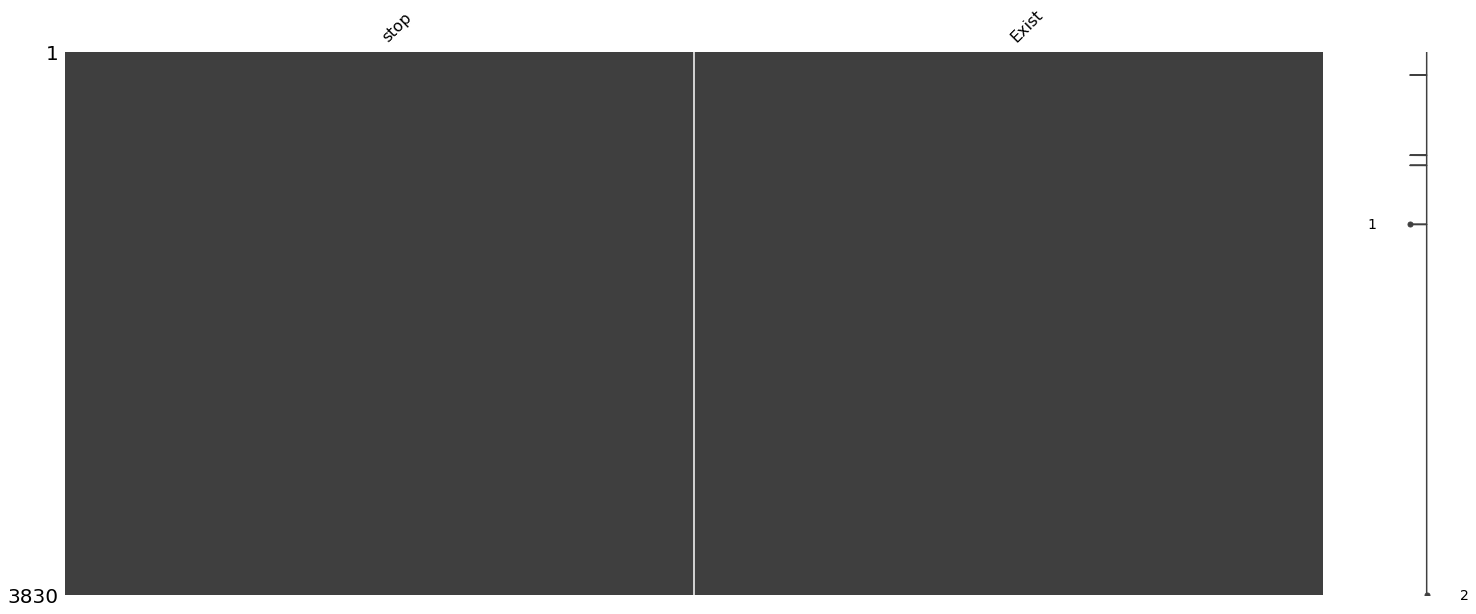

In [41]:
merged = elevationdf[["stop"]].drop_duplicates()
distances = distancedf[["stop"]].drop_duplicates()

if len(distances) == len(merged):
    print("No elevations missing from the merged data.")
else:
    mergedTest = pd.merge(distances, merged, how='outer', indicator='Exist')

mergedTest = mergedTest.replace("left_only", np.nan)
msno.matrix(mergedTest)
# mergedTest


In [27]:
import requests, zipfile, io

GTFS = requests.get(in_config.GTFSURL, stream=True)
GTFSRaw = zipfile.ZipFile(io.BytesIO(GTFS.content))

for each in GTFSRaw.namelist():
    GTFSDF = pd.read_csv(GTFSRaw.open(each), low_memory=False)
    print(GTFSDF.head())


  agency_id       agency_name                          agency_url  \
0       03C  GoAhead Commuter  https://www.transportforireland.ie   
1       978        Dublin Bus  https://www.transportforireland.ie   
2        01       Bus Éireann  https://www.transportforireland.ie   
3       01X        Expressway  https://www.transportforireland.ie   
4        03          Go-Ahead  https://www.transportforireland.ie   

  agency_timezone agency_lang  
0   Europe/Dublin          EN  
1   Europe/Dublin          EN  
2   Europe/Dublin          EN  
3   Europe/Dublin          EN  
4   Europe/Dublin          EN  
       route_id agency_id route_short_name  \
0  10-100-e19-1        01              100   
1  10-100-e20-1        01              100   
2  10-101-e19-1        01              101   
3  10-101-e20-1        01              101   
4  10-103-e19-1        01              103   

                         route_long_name  route_type  
0              Skerries (War Memorial) -           3  
1     

['agency.txt', 'routes.txt', 'trips.txt', 'stops.txt', 'calendar.txt', 'calendar_dates.txt', 'shapes.txt', 'transfers.txt', 'stop_times.txt']
